# **Modul: 3030 - GSA**


**Autoren:**  
Fabian Rüfenacht  
 Prof. Dr. Dante Salvini

Datum: 15.10.2024


# Geodätische Statistik & Ausgleichsrechnung - Freie Stationierung

Die im Feldkurs in Brienz (BE) durchgeführte Freie Stationierung soll mit Hilfe einer 
vermittelnden Ausgleichung nachgerechnet und mit der App-Lösung von Captivate 
auf der MS60 verglichen werden.

Es ist sicherzustellen, dass die im Felde gemessenen atmosphärisch korrigierten
Distanzen als Projektionsdistanzen (= in der Projektionsebene reduzierte Distanz) 
in der Ausgleichung verwendet werden (im LQP von Leica Geosystems sind diese 
nicht dokumentiert). Die Distanzreduktion ist allenfalls vorgängig zu berechnen.

### 1. Zielsetzung

Anhand der bisher vermittelten Theorie soll eine Freie Stationierung mittels 
Ausgleichung «manuell» berechnet werden, um das Prinzip der vermittelnden
Ausgleichung anhand eines eigenen nummerischen Beispiels praktisch zu 
vertiefen.

### 3. Aufgabenstellung

Die Freie Station soll mittels einer vermittelnden Ausgleichung streng ausgeglichen 
werden, und zwar in einer ersten Variante ohne Massstabsunbekannte und in einer 
zweiten Variante mit Massstabsunbekannte.
Gesucht sind:
- Die ausgeglichenen Koordinaten (nur Lage) der Freien Stationierung
- Genauigkeit der Koordinaten

### 3. Vorgehen
#### 3.1. Ausgleichung
1. Bestimmen Sie die Projektionsdistanzen (Vorbereitungsarbeit, falls nötig)
2. Veranschaulichen Sie die Situation graphisch und tragen Sie die n Beobachtungen und die u Unbekannten der Aufgabenstellung ein
3. Stellen Sie die Beobachtungsgleichungen auf (funktionales Modell)
4. Legen Sie die Näherungswerte für die Unbekannten fest
5. Bilden Sie anschliessend die Verbesserungsgleichungen und bestimmen Sie die Absolutglieder (f Vektor)
6. Berechnung Sie die Standardabweichungen der Beobachtungen (stochastisches Modell)
7. Definieren Sie die Gewichte der einzelnen Beobachtungen
8. Stellen Sie das System der Normalgleichungen auf
9. Lösen Sie das Normalgleichungssystem (Berechnung der Unbekannten)
10. Berechnung der ausgeglichenen Koordinaten der Freien Station
11. Bestimmen Sie die Verbesserungen an den Beobachtungen
12. Bestimmen Sie die ausgeglichenen Beobachtungen
13. Führen Sie die Schlussprobe und den Modelltest durch

#### 3.2 Genauigkeit (am 22.10.2024)
1. Bestimmen Sie die Anzahl der Messungen (n), der Unbekannten (u) und den Freiheitsgrad (f) der Ausgleichung.
2. Berechnen Sie die Genauigkeit der Koordinaten der Freien Station

### 4. Beobachtungen
Als Beobachtungen führen Sie Ihre eigenen Messungen aus dem Feldkurs in Brienz (2024) ein.

### 5. Hilfsmittel
Es wird empfohlen das vorliegende Jupyter-Notebook zu verwenden.


# Einrichten der Umgebung

**Systemvoraussetzungen**

Für die Übung müssen folgende Programme installiert sein. Für ältere Versionen ist die Funktionalität nicht garantiert.

|Programm|Version|
|----|----|
|Conda|24.5.0|
|Python|3.12.4|
|Visual Studio Code (o.ä.)|1.93.0|

**Environment aufsetzen** (nur falls nicht bereits gemacht! sonst nur ```pip install pandas```)

1. starten Sie das die ```Anaconda Prompt```
2. geben Sie folgenden Befehl ein ```conda create -n GSA python=3.12```
3. aktivieren Sie das Environment mit ```conda activate GSA```
4. installieren Sie numpy für Matrixoperationen mit ```pip install numpy pandas```
5. In diesem Notebook:
    - starten Sie VSCode neu
    - klicken Sie oben rechts auf ```Select Kernel``` um das Environment auszuwählen
    - wählen Sie ```Python Environments...``` --> ```GSA```


# Einlesen der Messwerte

In [42]:
import src.lqpReader as lqpReader

lqp_sections = lqpReader.parseLQP("./data/FS_CA_Montana.lqp")
resections = lqpReader.get_resections(lqp_sections)
setups = lqpReader.process_resections(resections)
measurements_dict = setups[0] # get all measurements of the first setup

print(measurements_dict)

{'name': '9900001', 'IH': 0.0, 'O': 2767600.56, 'N': 1158776.437, 'H': 1411.296, 'anschluesse': [{'name': '106', 'O': 2767574.484, 'N': 1158774.239, 'H': 1408.458, 'RH': 1.3, 'SD': 26.209, 'HD': 26.164, 'HZ': 294.6613, 'V': 103.7269}, {'name': '105', 'O': 2767599.158, 'N': 1158801.777, 'H': 1409.501, 'RH': 1.3, 'SD': 25.392, 'HD': 25.387, 'HZ': 396.4415, 'V': 101.2406}, {'name': '107', 'O': 2767601.696, 'N': 1158753.407, 'H': 1409.8, 'RH': 1.3, 'SD': 23.064, 'HD': 23.063, 'HZ': 196.8441, 'V': 100.582}, {'name': '104', 'O': 2767652.281, 'N': 1158779.872, 'H': 1408.838, 'RH': 1.3, 'SD': 51.857, 'HD': 51.844, 'HZ': 95.7875, 'V': 101.4078}]}


In [43]:
print(measurements_dict['O'],measurements_dict['N'])

2767600.56 1158776.437


In [44]:
# import src.lqpReader_old as lqpReader

# lqp_sections = lqpReader.parseLQP("./data/FS_Ca_Montana.lqp")
# resections = lqpReader.get_resections(lqp_sections)
# setups = lqpReader.process_resections(resections)
# measurements_dict = setups[0] # get all measurements of the first setup

# print(measurements_dict)

# Ausgleichung

1. Projektionsdistanzen bestimmen (vgl. Kapitel 4.3.1 Skript GMTG)

In [45]:
import numpy as np
import src.custom_print as cp
import pandas as pd

RHO = np.pi / 200
ERDRADIUS = 6_378_816 # meter

names = [obs["name"] for obs in measurements_dict["anschluesse"]]


SD = [obs["SD"] for obs in measurements_dict["anschluesse"]] # Schrägdistanzen in Liste schreiben
V = [obs["V"] for obs in measurements_dict["anschluesse"]] # Vertikalwinkel in Liste schreiben
e_coord = [obs["O"] for obs in measurements_dict["anschluesse"]] # Ostkoordinaten Anschlusspunkte in Liste schreiben
n_coord = [obs["N"] for obs in measurements_dict["anschluesse"]] # Nordkoordinaten Anschlusspunkte in Liste schreiben
heights = [obs["H"] for obs in measurements_dict["anschluesse"]] # Höhen Anschlusspunkte in Liste schreiben
directions = [obs["HZ"] for obs in measurements_dict["anschluesse"]] # Horizonalrichungen in Liste schreiben

dH = [np.sin(_zenitwinkel*RHO)*_schraegdist for _zenitwinkel, _schraegdist in zip(V, SD)] #TODO: Horizontaldistanz für jede Messung berechnen. Ersetze ... mit der Berechnung
d0 = [_dh-(_dh*(hoehe/(ERDRADIUS+hoehe))) for _dh, hoehe in zip(dH, heights)] # TODO: Distanz auf Höhe 0 berechnen. Ersetze ... mit der Berechnung
d_proj = [_d0+(_d0*((nord-1200000)**2/(2*ERDRADIUS**2))) for _d0, nord in zip(d0, n_coord)] # TODO: Projektionsdistanz berechnen. Ersetze ... mit der Berechnung

measurements = pd.DataFrame({ # Resultate in ein neues Dataframe schreiben um sie später einfacher wiederzuverwenden
    "Nr": names,
    "Ost": e_coord,
    "Nord": n_coord,
    "hoehe": heights,
    "HZ": directions,
    "dH": dH,
    "d0": d0,
    "dProj": d_proj,

    })

measurements.head()

,Nr,Ost,Nord,hoehe,HZ,dH,d0,dProj
0,106,2767574.4840,1158774.2390,1408.4580,294.6613,26.1641,26.1583,26.1589
1,105,2767599.1580,1158801.7770,1409.5010,396.4415,25.3872,25.3816,25.3821
2,107,2767601.6960,1158753.4070,1409.8000,196.8441,23.0630,23.0579,23.0584
3,104,2767652.2810,1158779.8720,1408.8380,95.7875,51.8443,51.8329,51.8340


2. Veranschaulichen Sie die Situation graphisch und tragen Sie die n Beobachtungen und die u Unbekannten der Aufgabenstellung ein

Fügen Sie den Screenshot in der untenstehenden Zelle ein.

*Bild hier einfügen*

3. Beobachtungsgleichungen aufstellen (funktionales Modell)

Fügen Sie einen Screenshot oder die Formel in der untenstehenden Zelle ein.

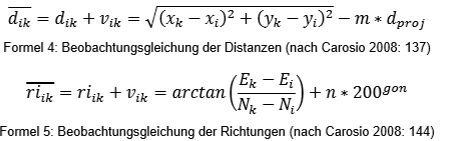

*Bild oder Formel*

Formelvorlage:
$$Distanz$$
$$\overline{d_{ik}} = d_{ik} + v = \sqrt{(x_{k} - x_{i})^2 + (y_{k} - y_{i})^2} ...$$

$$Richtungen$$
$$\overline{ri_{ik}} = ri_{ik} + v_{ik} = arctan(\frac{E_{k} - E_{i}}{N_{k} - N_{i}})...$$

4. Näherungswerte der Unbekannten & der Beobachtungen

In [46]:
# Näherungswerte der Unbekannten
e_approx_FS = measurements_dict["O"] #Näherungswert FS Ost
n_approx_FS = measurements_dict["N"] #Näherungswert FS Nord

def berechne_azimut(e_i, n_i, e_k, n_k):
    delta_E = e_k - e_i
    delta_N = n_k - n_i
    azimut_rad = np.arctan2(delta_E, delta_N)  # arctan2(y, x)

    # Radianten in Gon umrechnen
    azimut_gon = azimut_rad / (2 * np.pi) * 400

    # Azimut im Bereich [0, 400) gon halten
    if azimut_gon < 0:
        azimut_gon += 400

    return azimut_gon

measurements["Azi"] = [
    berechne_azimut(e_approx_FS, n_approx_FS, e, n)
    for e, n in zip(measurements["Ost"], measurements["Nord"])
] # TODO: Azimut aus Näherungskoordinate berechnen

measurements["Azi"] = np.where(measurements["Azi"] > 0, measurements["Azi"], measurements["Azi"] + 400) # Falls Azimut <0 ist, muss es korrigiert werden
measurements["Ori"] = measurements["Azi"] - measurements["HZ"] # TODO: Orientierung für jede Beobachtung bessen

ori_approx_FS = measurements["Ori"].mean() #TODO: geeigneten Näherungswert für die Orientierung berechnen
scale_approx_FS = 1 # TODO: geeigneten Näherungswert für den Massstab definieren

unknown_names = ['Ori', 'm', 'N', 'E'] # Namen der Unbekannten
approx_vect = np.array([ori_approx_FS, scale_approx_FS, n_approx_FS, e_approx_FS], np.float64) # Vektor mit allen Näherungswerten erstellen

print(e_approx_FS, n_approx_FS, ori_approx_FS, scale_approx_FS) # Ausgabe der Näherungswerte
# Überprüfung der Ergebnisse
print(measurements.head())


2767600.56 1158776.437 0.008456173871401518 1
    Nr          Ost         Nord     hoehe       HZ      dH      d0   dProj  \
0  106 2767574.4840 1158774.2390 1408.4580 294.6613 26.1641 26.1583 26.1589   
1  105 2767599.1580 1158801.7770 1409.5010 396.4415 25.3872 25.3816 25.3821   
2  107 2767601.6960 1158753.4070 1409.8000 196.8441 23.0630 23.0579 23.0584   
3  104 2767652.2810 1158779.8720 1408.8380  95.7875 51.8443 51.8329 51.8340   

       Azi     Ori  
0 294.6465 -0.0148  
1 396.4813  0.0398  
2 196.8623  0.0182  
3  95.7782 -0.0093  


In [47]:
# Näherungswerte der Unbekannten

def berechne_distanz(e_start, n_start, e_end, n_end):
    return np.sqrt((e_end - e_start) ** 2 + (n_end - n_start) ** 2)

measurements["naehDist"] = [
    berechne_distanz(e_approx_FS, n_approx_FS, e, n)
    for e, n in zip(measurements["Ost"], measurements["Nord"])
] #TODO: Distanz aus den Näherungswerten berechnen

# Korrigierte Horizontalrichtung berechnen (Orientierung wird als Unbekannte behandelt)
measurements["naehHZ"] = measurements["HZ"] + ori_approx_FS # TODO: die korrigierte Richtung setzt sich aus der Messung und der Orientierungsunbekannten zusammen.
measurements["naehHZ"] = np.where(measurements["naehHZ"] > 0, measurements["naehHZ"], measurements["naehHZ"] + 400) # Korrektur falls Wert <0

measurements.head()

,Nr,Ost,Nord,hoehe,HZ,dH,d0,dProj,Azi,Ori,naehDist,naehHZ
0,106,2767574.4840,1158774.2390,1408.4580,294.6613,26.1641,26.1583,26.1589,294.6465,-0.0148,26.1685,294.6698
1,105,2767599.1580,1158801.7770,1409.5010,396.4415,25.3872,25.3816,25.3821,396.4813,0.0398,25.3788,396.4500
2,107,2767601.6960,1158753.4070,1409.8000,196.8441,23.0630,23.0579,23.0584,196.8623,0.0182,23.0580,196.8526
3,104,2767652.2810,1158779.8720,1408.8380,95.7875,51.8443,51.8329,51.8340,95.7782,-0.0093,51.8349,95.7960


5. Verbesserungsgleichungen aufstellen und A-Matrix sowie f-Vektor bilden

Fügen Sie einen Screenshot der Verbesserungsgleichungen in die untenstehende Zelle ein.

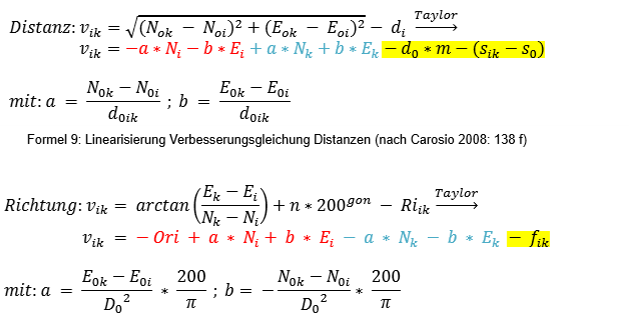

*Bild oder Formel der Verbesserungsgleichungen*

**$$Distanz$$**
$$v_{ik} = -cos(\alpha_{0} * x_{i}) - sin(\alpha_{0} * y_{i}) - d{0} * m - (d_{ik} - d_{0})$$

$$mit:$$
$$d_{0} = Projektionsdistanz \ aus \ Näherungswerten$$
$$d_{ik} = Projektionsdistanz \ aus \ Messung$$

**$$Richtungen$$**

In [48]:
print(measurements.columns)

Index(['Nr', 'Ost', 'Nord', 'hoehe', 'HZ', 'dH', 'd0', 'dProj', 'Azi', 'Ori',
       'naehDist', 'naehHZ'],
      dtype='object')


In [49]:
print(unknown_names)

['Ori', 'm', 'N', 'E']


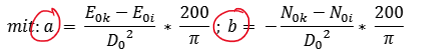

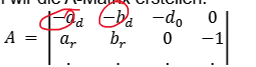

In [50]:
no_obs = 2 * measurements.shape[0] # jeweils Distanz und Richtung
no_unknowns = len(unknown_names) # E, N, Ori, Massstab
A_mat = np.zeros((no_obs, no_unknowns))

for idx, i in measurements.iterrows():    

    # Übertragungsfaktoren Richtung   --> zb kein Massstab
    A_mat[idx][0] = -1 # TODO: Übertragungsfaktor für die Orientierung berechnen (falls nötig)
    A_mat[idx][1] = 0 # TODO: Übertragungsfaktor für die Distanz berechnen (falls nötig)
    A_mat[idx][2] = (i['Ost'] - e_approx_FS) / i["naehDist"]**2 / RHO # TODO: Übertragungsfaktor für die Noordkoordinate berechnen (falls nötig)
    A_mat[idx][3] = - (i['Nord'] - n_approx_FS) / i["naehDist"]**2 / RHO# TODO: Übertragungsfaktor für die Ostkoordinate berechnen (falls nötig)
    
    # Übertragungsfaktoren Distanz
    A_mat[idx + no_obs // 2][0] = 0 # TODO: Übertragungsfaktor für die Orientierung berechnen (falls nötig)
    A_mat[idx + no_obs // 2][1] = -i["naehDist"]/1000 # TODO: Übertragungsfaktor für die Distanz berechnen (falls nötig)
    A_mat[idx + no_obs // 2][2] =  - (i['Nord'] - n_approx_FS) / i["naehDist"] # TODO: Übertragungsfaktor für die Noordkoordinate berechnen (falls nöti
    A_mat[idx + no_obs // 2][3] =  - (i['Ost'] - e_approx_FS) / i["naehDist"] # TODO: Übertragungsfaktor für die Ostkoordinate berechnen (falls nötig)

obs_names = [str(i) + " ri" for i in names] + [str(i) + " di" for i in names] # Namen der Beobachtungen in einer Liste speichern  

cp.mat_nxu(A_mat, row_names=obs_names, col_names=unknown_names)

           Ori       m       N       E
106 ri -1.0000  0.0000 -2.4242  0.2043
105 ri -1.0000  0.0000 -0.1386 -2.5046
107 ri -1.0000  0.0000  0.1360  2.7576
104 ri -1.0000  0.0000  1.2255 -0.0814
106 di  0.0000 -0.0262  0.0840  0.9965
105 di  0.0000 -0.0254 -0.9985  0.0552
107 di  0.0000 -0.0231  0.9988 -0.0493
104 di  0.0000 -0.0518 -0.0663 -0.9978


In [51]:
# weil nicht lineares gleichungssystem -> f-vektor durch messen - genährt bilden

In [52]:
f_HZ = list(measurements['naehHZ'] - measurements['Azi'] ) # TODO: Berechnen des Absolutigliedes für Horizontalrichtungen. Ersetzen Sie ... mit der Berechnung. Richtungsbeobachtungen
f_dist = list(measurements['dProj'] - measurements['naehDist']) # TODO: Berechnen des Absolutigliedes für Distanzen. Ersetzen Sie ... mit der Berechnung.
f_vect = np.array(f_HZ + f_dist, np.float64) * 1000 # in mm / mgon umrechnen, damit die Resultate in geeigneter Einheit erscheinen. Die beiden Listen (f_HZ & F_dist) werden aneinandergereiht.


cp.vect(f_vect, row_names=obs_names, unknowns=True)

               
106 ri  23.3007
105 ri -31.3703
107 ri  -9.7349
104 ri  17.8046
106 di  -9.6010
105 di   3.3447
107 di   0.4214
104 di  -0.9852


c:\Users\Ignaz\Desktop\Studium\Module\IT\GIT\Excercises\u04-freie-stationierung-calgon854\src\custom_print.py:58: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: round(x, accuracy) if isinstance(x, (int, float)) else x)


6. Standardabweichungen der Beobachtungen (stochastisches Modell)

In [53]:
# folgende 4 Werte können bei Bedarf verändert werden
SIGMA0 = 1
SIGMARI = 0.3 #mgon
sigma_Di_const = 1
sigma_Di_ppm = 1.5

# Funktion zur Berechnung der Genauigkeit der Distanz
def getSigmaDi(distance: float) -> float:
    return sigma_Di_const + (distance * sigma_Di_ppm / 1000) #TODO: 0 mit der Berechnung ersetzen. Resultat soll die Genauigkeit einer Messung sein
    
measurements["stabwRI"] = SIGMARI ###TODO: 0 mit Genauigkeit einer Richtungsmessung ersetzen. Es wird nicht über die Distanz gewichtet
measurements["stabwDist"] = getSigmaDi(distance=measurements["naehDist"]) # Berechnen der Stabw. einer Distanz
# print(measurements.head())

std_obs = np.array(list(measurements["stabwRI"]) + list(measurements["stabwDist"]), np.float64) # Die Standardabweichungen werden in einen Vektor geschrieben

cp.vect(std_obs, row_names=obs_names, title="Stab. Beob.")

        Stab. Beob.
106 ri       0.3000
105 ri       0.3000
107 ri       0.3000
104 ri       0.3000
106 di       1.0393
105 di       1.0381
107 di       1.0346
104 di       1.0778


c:\Users\Ignaz\Desktop\Studium\Module\IT\GIT\Excercises\u04-freie-stationierung-calgon854\src\custom_print.py:58: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: round(x, accuracy) if isinstance(x, (int, float)) else x)


7. Gewichte der Beobachtungen festlegen und Gewichtsmatrix P bilden

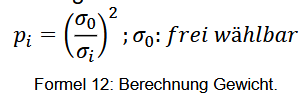

In [54]:
p_i = (SIGMA0 / std_obs) ** 2 # TODO: 0 mit der Berechnung der Gewichte ersetzen

P_mat = np.zeros((no_obs, no_obs))

for idx, i in enumerate(p_i): # Der Vektor (p_i) wird in eine Diagonalmatrix umgerechnet
    P_mat[idx][idx] = i
    
cp.mat_nxn(P_mat, obs_names)

        106 ri  105 ri  107 ri  104 ri  106 di  105 di  107 di  104 di
106 ri 11.1111  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
105 ri  0.0000 11.1111  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
107 ri  0.0000  0.0000 11.1111  0.0000  0.0000  0.0000  0.0000  0.0000
104 ri  0.0000  0.0000  0.0000 11.1111  0.0000  0.0000  0.0000  0.0000
106 di  0.0000  0.0000  0.0000  0.0000  0.9259  0.0000  0.0000  0.0000
105 di  0.0000  0.0000  0.0000  0.0000  0.0000  0.9280  0.0000  0.0000
107 di  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.9343  0.0000
104 di  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.8609


In [55]:
# ri gleich weil oben formuliert ||p_i = (SIGMA0 / std_obs) ** 2  || ______  ----> distanz p unterschiedlich weil ppm gleich

8. Normalgleichungssystem aufstellen *zusammen mit Schritt 9*
9. Berechnung der Unbekannten

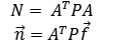

# Normalgleichungssystem: A.T @ P @ A @ x - A.T @ P @ f = 0

In [56]:
N_mat = A_mat.T @ P_mat @ A_mat #TODO: Berechnung der N-Matrix

cp.mat_nxn(N_mat, unknown_names)

        Ori      m       N        E
Ori 44.4444 0.0000 13.3473  -4.1767
m    0.0000 0.0040  0.0029   0.0201
N   13.3473 0.0029 84.2687   1.4494
E   -4.1767 0.0201  1.4494 156.5145


In [57]:
Qxx_mat = np.linalg.inv(N_mat) # Berechnung der Qxx-Matrix = inv(N-Matrix)
cp.mat_nxn(Qxx_mat, unknown_names)

        Ori        m       N       E
Ori  0.0237  -0.0006 -0.0038  0.0007
m   -0.0006 247.5892 -0.0079 -0.0318
N   -0.0038  -0.0079  0.0125 -0.0002
E    0.0007  -0.0318 -0.0002  0.0064


In [58]:
n_vect = A_mat.T @ P_mat @ f_vect # TODO: Berechnung des n-Vektors

cp.vect(n_vect, row_names=unknown_names)

             
Ori   -0.0000
m      0.1887
N   -354.9850
E    603.6823


c:\Users\Ignaz\Desktop\Studium\Module\IT\GIT\Excercises\u04-freie-stationierung-calgon854\src\custom_print.py:58: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: round(x, accuracy) if isinstance(x, (int, float)) else x)


#verkürzte unbekannte

In [59]:
x_vect = Qxx_mat @ n_vect # TODO: Berechnung Vektor der verkürzten Unbekannten

cp.vect(x_vect, row_names=unknown_names)

           
Ori  1.7389
m   30.3455
N   -4.5568
E    3.9417


c:\Users\Ignaz\Desktop\Studium\Module\IT\GIT\Excercises\u04-freie-stationierung-calgon854\src\custom_print.py:58: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: round(x, accuracy) if isinstance(x, (int, float)) else x)


10. Ausgeglichene Koordinaten der freien Station

In [60]:
# print(X_vect)

In [61]:
X_vect = approx_vect + x_vect/1000  #um von mm auf m
X_vect[1] = (X_vect[1]- scale_approx_FS) / 1000 + scale_approx_FS # km -> m 
# Volle Unbekannte in einzelne Variabeln speichern
FS_E = X_vect[3]
FS_N =  X_vect[2]
FS_Ori =  X_vect[0]
FS_msstb =  X_vect[1]

cp.vect(X_vect, row_names=unknown_names, accuracy=6)

                  
Ori       0.010195
m         1.000030
N   1158776.432443
E   2767600.563942


c:\Users\Ignaz\Desktop\Studium\Module\IT\GIT\Excercises\u04-freie-stationierung-calgon854\src\custom_print.py:58: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: round(x, accuracy) if isinstance(x, (int, float)) else x)


11. Verbesserungen der Beobachtungen

In [62]:
# Berechnen Sie die Verbesserungen mittels Matrixmultiplikation

v_vect_mgon_mm = A_mat @ x_vect -f_vect    


cp.vect(v_vect_mgon_mm, row_names=obs_names, title="Verbesserungen [mm, mgon]")

        Verbesserungen [mm, mgon]
106 ri                   -13.1876
105 ri                    20.3903
107 ri                    18.2459
104 ri                   -25.4485
106 di                    12.3520
105 di                     0.6527
107 di                    -5.8666
104 di                    -4.2189


c:\Users\Ignaz\Desktop\Studium\Module\IT\GIT\Excercises\u04-freie-stationierung-calgon854\src\custom_print.py:58: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: round(x, accuracy) if isinstance(x, (int, float)) else x)


In [63]:
# # Berechnen Sie die Verbesserungen aus der Beobachtungsgleichung
# v_BGL = np.zeros((measurements.shape[0] * 2, 1), np.float64) # Null-Vektor mit der richtigen Dimension erstellen

# for idx, i in measurements.iterrows():    
#     #Verbesserungen der Richtung
#     ri_naeh = i['Azi'] + v_vect[idx] #TODO: genäherte Richtung (Azimut) mit den ausgeglichenen Unbekannten berechnen
#     ri_naeh = ri_naeh if ri_naeh >= 0 else ri_naeh + 400 # positiv setzen falls nötig

#     #stimmt nicht
#     ri_gem = i['Azi'] + v_vect[idx] # TODO: gemessene Richtungen mit der ausgeglichenen Orientierung ergänzen
#     ri_gem = ri_gem if ri_gem >= 0 else ri_gem + 400 # positiv setzen falls nötig
#     v_BGL[idx] = ri_gem - i['Azi'] # Verbesserung aus der BGL berechnen
    
#     # Verbesserungen Distanz
#     v_BGL[idx + measurements.shape[0]] = 0 # TODO: Verbesserungen der Distanz aus der BGL berechnen

# v_BGL_mgon_mm = [v[0] * 1000 for v in v_BGL] # Verbesserungen umrechnen um wieder mm / mgon zu erhalten (für den Vergleich) (erfolgt nächste Lektion)

# cp.vect(v_BGL_mgon_mm, row_names=obs_names, title="Verbesserungen aus BGL [mm, mgon]")

12. ausgeglichene Beobachtungen

In [64]:
l_measured = list(measurements["naehDist"]) + list(measurements["Azi"]) # Beobachtungen in einem Vektor speichern
l_aligned = l_measured + v_vect_mgon_mm / 1000 # TODO: Berechnung der ausgeglichenen Beobachtungen

print("-"*3, "Ausgeglichene Beobachtungen", "-"*3)
cp.vect(l_aligned, row_names=obs_names, title="ausgeglichene Beobachtungen")

print("\n", "-"*3, "Differenz ausgeglichen - gemessen == Verbesserung", "-"*3)
for i in range(len(l_measured)):
    difference = l_aligned[i] - l_measured[i]
    print(f"{difference:.4f}")

--- Ausgeglichene Beobachtungen ---
        ausgeglichene Beobachtungen
106 ri                      26.1553
105 ri                      25.3991
107 ri                      23.0762
104 ri                      51.8095
106 di                     294.6588
105 di                     396.4820
107 di                     196.8564
104 di                      95.7739

 --- Differenz ausgeglichen - gemessen == Verbesserung ---
-0.0132
0.0204
0.0182
-0.0254
0.0124
0.0007
-0.0059
-0.0042


c:\Users\Ignaz\Desktop\Studium\Module\IT\GIT\Excercises\u04-freie-stationierung-calgon854\src\custom_print.py:58: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: round(x, accuracy) if isinstance(x, (int, float)) else x)


# Genauigkeit

1. Bestimmen Sie die Anzahl der Messungen (n), der Unbekannten (u) und den Freiheits-grad (f).

In [65]:
n = 8 # TODO: Anzahl Beobachtungen   #no_obs
u = 4 # TODO: Anzahl unbekannte         #no_unknowns
f = n- u  # TODO: Freiheitsgrad berechnen

print(f"Anzahl Messungen: {n}, Anzahl Unbekannte: {u}, Freiheitsgrad: {f}")

Anzahl Messungen: 8, Anzahl Unbekannte: 4, Freiheitsgrad: 4


2. Modelltest

In [66]:
# np.shape(v_vect)

In [67]:
np.shape(Qxx_mat)

(4, 4)

In [68]:
#s0 genauigkeit a posteriori 

In [69]:
s0 = np.sqrt((v_vect_mgon_mm.T @ P_mat @ v_vect_mgon_mm) / (n - u)) # TODO: s0 berechnen

F = s0**2 / SIGMA0**2 # TODO: Testgrösse F berechnen

MODELLTEST_THRESHHOLD = 2.3 # TODO: Finden Sie die Grenze für den Modelltest (Tipp: Statistik-Tabellen verwenden)

print(f"Standardabweichung a posteriori: {s0}\nTestgrösse F: {F}")

# Durchführung Modelltest
if F <= MODELLTEST_THRESHHOLD:
    print("Der Modelltest wurde bestanden. Modell akzeptiert!")
else:
    print("Der Modelltest wurde NICHT bestanden. Modell verworfen!")

Standardabweichung a posteriori: 66.40025066902534
Testgrösse F: 4408.9932889094
Der Modelltest wurde NICHT bestanden. Modell verworfen!


3. Genauigkeit der Koordinaten FS

In [70]:
print(Qxx_mat)

[[ 2.36931545e-02 -6.04266462e-04 -3.76422156e-03  6.67203860e-04]
 [-6.04266462e-04  2.47589212e+02 -7.94163785e-03 -3.18088799e-02]
 [-3.76422156e-03 -7.94163785e-03  1.24669895e-02 -2.14876762e-04]
 [ 6.67203860e-04 -3.18088799e-02 -2.14876762e-04  6.41307244e-03]]


In [71]:
# Genauigkeiten der Unbekannten berechnen
sE = s0*np.sqrt(Qxx_mat[3,3]) # TODO: Stabw. Ost-Koordinate
sN = s0*np.sqrt(Qxx_mat[2,2]) # TODO: Stabw. Nord-Koordinate
sOri = s0*np.sqrt(Qxx_mat[0,0]) # TODO: Stabw. Orientierung
sMsstb = s0*np.sqrt(Qxx_mat[1,1]) # TODO: Stabw. Massstab

s_vect = np.array([sOri, sMsstb, sN, sE]) # Genauigkeiten in einem Vektor speichern

print(f"Standardabweichung E: {sE:.4f} mm, Standardabweichung N: {sN:.4f} mm")

Standardabweichung E: 5.3174 mm, Standardabweichung N: 7.4140 mm


4. Schlussprobe

In [72]:
# GRENZWERT_VERBESSERUNGEN = 10**(-2) # Wir vergleichen die Verbesserungen im Millimeter-Bereich -> Wenn Verbesserungen auf 0.01 mm / mgon zusammenpassen, sind wir mit den Näherungswerten zufrieden

# idx = 0
# for v, v_ in zip(v_vect_mgon_mm, v_BGL_mgon_mm):
#     assert abs(v - v_) <= GRENZWERT_VERBESSERUNGEN, f"Schlussprobe nicht bestanden! Verbesserung {idx}: {(v - v_):6f}" # Bedeutung der Code-Zeile: "assert" wir gehen davon aus, dass der Betrag der Differenz der Verbesserung < dem Grenzwert ist. Ist dies nicht der Fall werfen wir eine Fehlermeldung -> Test nicht bestanden
#     idx += 1
    
print("Schlussprobe bestanden!")

Schlussprobe bestanden!


5. Ausgabe der Unbekannten & Genauigkeit

In [73]:
print(f"Orientierung: {X_vect[0]:.4f} gon ± {s_vect[0]:.2f} mgon")
print(f"Massstab: {X_vect[1]:.6f} ± {s_vect[1]:.2f} ppm")
print(f"Nord: {X_vect[2]:.4f} m ± {s_vect[2]:.2f} mm")
print(f"Ost: {X_vect[3]:.4f} m ± {s_vect[3]:.2f} mm")

Orientierung: 0.0102 gon ± 10.22 mgon
Massstab: 1.000030 ± 1044.81 ppm
Nord: 1158776.4324 m ± 7.41 mm
Ost: 2767600.5639 m ± 5.32 mm


In [74]:
cp.mat_nxn(Qxx_mat, unknown_names)

        Ori        m       N       E
Ori  0.0237  -0.0006 -0.0038  0.0007
m   -0.0006 247.5892 -0.0079 -0.0318
N   -0.0038  -0.0079  0.0125 -0.0002
E    0.0007  -0.0318 -0.0002  0.0064


#vergleich mit formeln von dante

In [75]:
qxx = Qxx_mat[2][2]
qyy = Qxx_mat[3][3]
qxy = Qxx_mat[2][3]
 
mean_qxxyy = (qxx + qyy) / 2
const = np.sqrt(((qxx - qyy) / 2)**2 + qxy**2)
 
ell_a_priori = np.sqrt(SIGMA0**2 * (mean_qxxyy + const))
ell_b_priori = np.sqrt(SIGMA0**2 * (mean_qxxyy - const))
ell_omega_priori =  0.5 * np.arctan2(2* qxy, (qxx - qyy)) / RHO

In [85]:
#anstatt sigma0 -< s0

In [76]:
ell_a_posteriori = np.sqrt(s0**2 * (mean_qxxyy + const))
ell_b_posteriori = np.sqrt(s0**2 * (mean_qxxyy - const))
ell_omega_posteriori = ell_omega_priori
print(ell_a_posteriori, ell_b_posteriori, ell_omega_posteriori)

7.416229328643726 5.3142834971965875 -2.2558238641886943


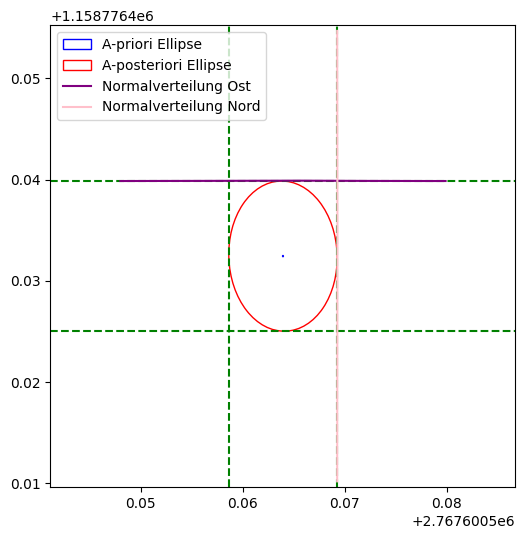

In [78]:
from src.accuracy_plot import plot_1
 
plot_1(ell_a_priori, ell_b_priori, ell_omega_priori, ell_a_posteriori, ell_b_posteriori, ell_omega_posteriori, sE, sN, FS_E, FS_N)

In [ ]:
# helmert punktfehler berechnen

In [79]:
# a priori
radius_priori = SIGMA0 * np.sqrt(sE**2 + sN**2) / s0
radius_posteriori = np.sqrt(sE**2 + sN**2)
 
# a posteriori
print(radius_priori, radius_posteriori)

0.1374047378199624 9.12370903435721


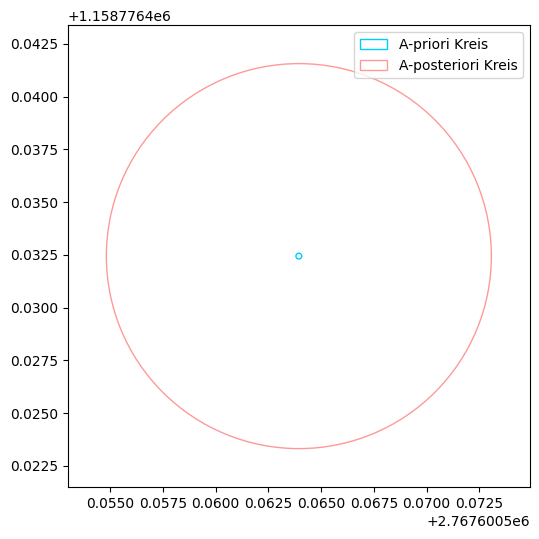

In [81]:
from src.accuracy_plot import plot_2
 
plot_2(radius_priori, radius_posteriori, FS_E, FS_N)

In [82]:
k = 3.4
a95 = ell_a_posteriori * k
b95 = ell_b_posteriori * k
omega95 = ell_omega_posteriori

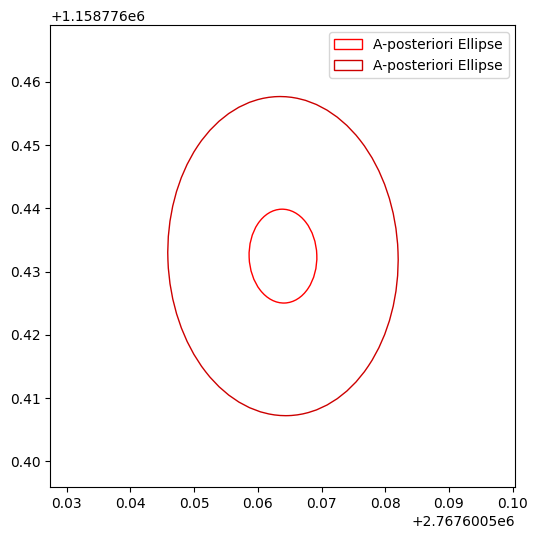

In [84]:
from src.accuracy_plot import plot_3
 
plot_3(ell_a_posteriori, ell_b_posteriori, ell_omega_posteriori, a95, b95, omega95, sE, sN, FS_E, FS_N)

In [ ]:
# plt.show()

NameError: name 'plt' is not defined